In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mp
import sklearn
from IPython.display import Image, HTML

import laUtilities as ut

%matplotlib inline

# Recommender Systems

Today, we look at a topic that has become enormously important in society: recommender systems.

We will
* Define recommender systems
* Review the challenges they pose
* Discuss two classic methods:
    * Collaborative Filtering
    * Matrix Factorization

```{note}
This section draws heavily on 
* These [slides](http://alex.smola.org/teaching/berkeley2012/slides/8_Recommender.pdf) by Alex Smola
* [Matrix Factorization Techniques for Recommender Systems,](https://ieeexplore.ieee.org/document/5197422) by Yehuda Koren, Robert Bell, and Chris Volinsky, and
* [Collaborative Filtering with Temporal Dynamics,](https://dl.acm.org/doi/10.1145/1557019.1557072) by Yehuda Koren
```

## What are Recommender Systems?

The concept of recommender systems emerged in the late 1990s / early 2000s as social life moved online:
* online purchasing and commerce
* online discussions and ratings
* social information sharing

In these systems content was exploding and users were having a hard time finding things they were interested in.

Users wanted recommendations.

Over time, the problem has only gotten worse:

<center>
    
<img src="figs/L20-netflix-options.png" alt="Figure" width="100%">
    
</center>

<center>
    
<img src="figs/L20-amazon-options.png" alt="Figure" width="100%">
    
</center>

An enormous need has emerged for systems to help sort through products, services, and content items.

This often goes by the term __personalization.__

Some examples:
    
* Movie recommendation (Netflix, YouTube)
* Related product recommendation (Amazon)
* Web page ranking (Google)
* Social content filtering (Facebook, Twitter)
* Services (Airbnb, Uber, TripAdvisor)
* News content recommendation (Apple News)
* Priority inbox & spam filtering (Google)
* Online dating (OK Cupid)

A more formal view:
    
* User - requests content
* Objects - that can be displayed
* Context - device, location, time
* Interface - browser, mobile

<center>
    
<img src="figs/L20-recsys-abstractly.png" alt="Figure" width="45%">
    
</center>

## Inferring Preferences

Unfortunately, users generally have a hard time __explaining__ what types of content they prefer.   Some early systems worked by interviewing users to ask what they liked.  Those systems did not work very well.

```{note}
A very interesting article about the earliest personalization systems is [User Modeling via Stereotypes](https://www.cs.utexas.edu/users/ear/CogSci.pdf) by Elaine Rich, dating from 1979.
```

Instead, modern systems work by capturing user's opinions about __specific__ items.

This can be done actively:
* When a user is asked to **rate** a movie, product, or experience,

Or it can be done passively:
* By noting which items a user **chooses** to purchase (for example).

<center>
    
<img src="figs/L20-example-data.png" alt="Figure" width="55%">
    
</center>

## Challenges

* The biggest issue is __scalability__: typical data for this problem is huge.
  * Millions of objects
  * 100s of millions of users
* Changing user base
* Changing inventory (movies, stories, goods)
* Available features
* Imbalanced dataset
    * User activity / item reviews are power law distributed    

```{note}
This data is a subset of the data presented in: "From amateurs to connoisseurs: modeling the evolution of user expertise through online reviews," by J. McAuley and J. Leskovec. WWW, 2013
```

In [2]:
# This is a 1.7 GB file, delete it after use
import os.path
if not os.path.exists('train.csv'):
    os.system('kaggle competitions download -c cs-506-midterm-a1-b1')
    os.system('unzip cs-506-midterm-a1-b1.zip')

100%|██████████| 650M/650M [02:29<00:00, 4.57MB/s] 



Archive:  cs-506-midterm-a1-b1.zip
  inflating: sample.csv              
  inflating: test.csv                
  inflating: train.csv               


In [3]:
df = pd.read_csv('train.csv')

In [4]:
n_users = df["UserId"].unique().shape[0]
n_movies = df["ProductId"].unique().shape[0]
n_reviews = len(df)
print(f'There are {n_reviews} reviews, {n_movies} movies and {n_users} users.')
print(f'There are {n_users * n_movies} potential reviews, meaning sparsity of {(n_reviews/(n_users * n_movies)):0.4%}')

There are 1697533 reviews, 50052 movies and 123960 users.
There are 6204445920 potential reviews, meaning sparsity of 0.0274%


__Reviews are Sparse.__

Example: A commonly used dataset for testing consists of Amazon movie reviews:
* 1,697,533 reviews
* 123,960 users
* 50,052 movies

Notice that there are 6,204,445,920 __potential__ reviews, but we only have 1,697,533 __actual__ reviews.

Only 0.02% of the reviews are available -- 99.98% of the reviews are missing.

In [5]:
print(f'There are on average {n_reviews/n_movies:0.1f} reviews per movie' +
     f' and {n_reviews/n_users:0.1f} reviews per user')

There are on average 33.9 reviews per movie and 13.7 reviews per user


__Sparseness is skewed.__

Although on average a movie receives 34 reviews, __almost all movies have even fewer reviews.__

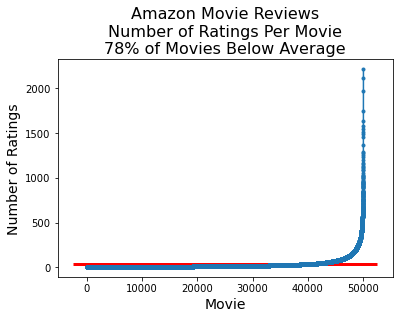

In [6]:
reviews_per_movie = df.groupby('ProductId').count()['Id'].values
frac_below_mean = np.sum(reviews_per_movie < (n_reviews/n_movies))/len(reviews_per_movie)
plt.plot(sorted(reviews_per_movie), '.-')
xmin, xmax, ymin, ymax = plt.axis()
plt.hlines(n_reviews/n_movies, xmin, xmax, 'r', lw = 3)
plt.ylabel('Number of Ratings', fontsize = 14)
plt.xlabel('Movie', fontsize = 14)
plt.title(f'Amazon Movie Reviews\nNumber of Ratings Per Movie\n' +
          f'{frac_below_mean:0.0%} of Movies Below Average', fontsize = 16);

Likewise, although the average user writes 14 reviews, almost all users write even fewer reviews.

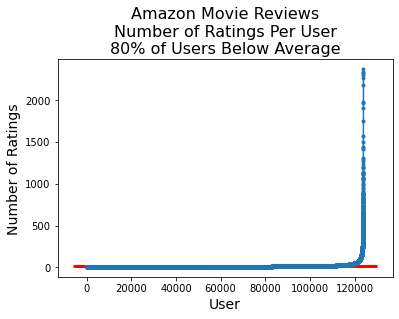

In [7]:
reviews_per_user = df.groupby('UserId').count()['Id'].values
frac_below_mean = np.sum(reviews_per_user < (n_reviews/n_users))/len(reviews_per_user)
plt.plot(sorted(reviews_per_user), '.-')
xmin, xmax, ymin, ymax = plt.axis()
plt.hlines(n_reviews/n_users, xmin, xmax, 'r', lw = 3)
plt.ylabel('Number of Ratings', fontsize = 14)
plt.xlabel('User', fontsize = 14)
plt.title(f'Amazon Movie Reviews\nNumber of Ratings Per User\n' +
          f'{frac_below_mean:0.0%} of Users Below Average', fontsize = 16);

A typical objective function is root mean square error (RMSE)

$$ \text{RMSE} = \sqrt{1/|S| \sum_{(i,u)\in S} (\hat{r}_{ui} - r_{ui})^2} $$

where $ r_{ui} $ is the rating that user $u$ gives to item $i$, and $S$ is the set of all ratings.

OK, now we know the problem and the data available.   How can we address the problem?

The earliest method developed is called __collaborative filtering.__

## Collaborative Filtering

The central idea of collaborative filtering is that the set of known recommendations can be considered to be a __bipartite graph.__

<center>
    
<img src="figs/L20-bipartite.png" alt="Figure" width="35%">
    
</center>

The nodes of the bipartite graph are __users__ and __items__.   

Each edge corresponds to a known rating $r_{ui}.$

Then recommendations are formed by traversing or processing the bipartite graph.

<center>
    
<img src="figs/L20-cf-basic-idea.png" alt="Figure" width="60%">
    
</center>

There are at least two ways this graph can be used.

To form a rating for item $(u, i)$: 
    
1. Using user-user similarity:
      * look at users that have similar item preferences to user $u$
      * look at how those users rated item $i$
      
Good for many users, fewer items

    
2. Using item-item similarity:
      * look at other items that have been liked by similar users as item $i$
      * look at how user $u$ rated those items
      
Good for many items, fewer users

### Item-item CF

Let's look at the item-item CF approach in detail.

The questions are:
* How do we judge "similarity" of items?
* How do we form a predicted rating?

Here is another view of the ratings graph, this time as a matrix that includes missing entries:

<center>
    
<img src="figs/L20-u-u-cf-1.png" alt="Figure" width="60%">
    
</center>

Let's say we want to predict the value of this unknown rating:

<center>
    
<img src="figs/L20-u-u-cf-2.png" alt="Figure" width="60%">
    
</center>

We'll consider two other items, namely items 3 and 6 (for example).

Note that we are only interested in items that this user has rated.

<center>
    
<img src="figs/L20-u-u-cf-3.png" alt="Figure" width="60%">
    
</center>

We will discuss strategies for assessing similarity shortly. 

How did we choose these two items?   

We used __$k$-nearest neighbors__.   Here $k$ = 2.

For now, let's just say we determine the similarities as:

$$ s_{13} = 0.2 $$

$$ s_{16} = 0.3 $$

<center>
    
<img src="figs/L20-u-u-cf-3.png" alt="Figure" width="60%">
    
</center>

These similarity scores tell us how much weight to put on the rating of the other items.

So we can form a prediction of $\hat{r}_{15}$ as:
    
$$ \hat{r}_{15} = \frac{s_{13} \cdot r_{35} + s_{16} \cdot r_{65}}{s_{13} + s_{16}} = \frac{0.2 \cdot 2 + 0.3 \cdot 3}{0.2 + 0.3} = 2.6 $$

<center>
    
<img src="figs/L20-u-u-cf-4.png" alt="Figure" width="60%">
    
</center>

### Similarity

How should we assess similarity of items?

A reasonable approach is to consider items similar if their ratings are __correlated.__

So we can use the Pearson correlation coefficient $r$.

However, note that two items will not have ratings in the same positions.

<center>
    
<img src="figs/L20-corr-support.png" alt="Figure" width="60%">
    
</center>

So we want to compute correlation only over the users who rated both the items.

In some cases we will need to work with binary $r_{ui}$s.  

For example, purchase histories on an e-commerce site, or clicks on an ad.

In this case, an appropriate replacement for Pearson $r$ is the Jaccard similarity coefficient.

(See the lecture on similarity measures.)

### Improving CF

One problem with the story so far arises due to __bias__.
* Some items are significantly higher or lower rated
* Some users rate substantially higher or lower in general

These properties interfere with similarity assessment.  

Bias correction is crucial for CF recommender systems.

We need to include
* Per-user offset
* Per-item offset
* Global offset

Hence we need to form a per-item bias of:
    
$$ b_{ui} = \mu + \alpha_u + \beta_i $$

where $\alpha_u$ is the per-user offset of user $u$ and $\beta_i$ is the per-item offset of item $i$.

How can we estimate the $\alpha$s, the $\beta$s, and the $\mu$?

Let's assume for a minute that we had a fully-dense matrix of ratings $R$.

$R$ has items on the rows and users on the columns.

Then what we want to estimate is

$$\min_{\alpha,\beta,\mu} \Vert R - \mathbf{1}\alpha^T + \beta\mathbf{1}^T + \mu1\Vert^2 + \lambda(\Vert\alpha\Vert^2 + \Vert\beta\Vert^2) $$

Here, $\mathbf{1}$ represents appropriately sized vectors of ones, and $1$ is a matrix of ones.

While this is not a simple ordinary least squares problem, there is a strategy for solving it.

Assume we hold $\beta\mathbf{1}^T + \mu1$ constant.  

Then the remaining problem is 

$$\min_{\alpha} \Vert R - \mathbf{1}\alpha^T \Vert^2 + \lambda \Vert\alpha\Vert^2 $$

which (for each column of $R$) is a standard least squares problem (which we solve via Ridge regression).

This sort of problem is called __jointly convex__.   

The strategy for solving is:
    
1. Hold $\alpha$ and $\beta$ constant, solve for $\mu$.
2. Hold $\alpha$ and $\mu$ constant, solve for $\beta$.
3. Hold $\beta$ and $\mu$ constant, solve for $\alpha$.

Each of the three steps will reduce the overall error.   So we iterate over them until convergence.

The last issue is that the matrix $R$ is not dense - in reality we only have a small subset of its entries.

We simply need to adapt the least-squares solution to only consider the entries in $R$ that we know.

As a result, the actual calculation is:

Step 1:

$$ \mu = \frac{\sum_{(u, i) \in R} (r_{ui} - \alpha_u - \beta_i)}{|R|} $$

Step 2: 

$$ \alpha_u = \frac{\sum_{i \in R(u)}(r_{ui} - \mu - \beta_i)}{\lambda + |R(u)|} $$

Step 3:
    
$$ \beta_i = \frac{\sum_{u \in R(i)}(r_{ui} - \mu - \alpha_u)}{\lambda + |R(i)|} $$

Step 4: If not converged, go to Step 1.


Now that we have the biases learned, we can do a better job of estimating correlation:

$$ \hat{\rho}_{ij} = \frac{\sum_{u\in U(i,j)}(r_{ui} - b_{ui})(r_{uj}-b_{uj})} 
{\sqrt{\sum_{u\in U(i,j)}(r_{ui} - b_{ui})^2\sum_{u\in U(i,j)}(r_{uj}-b_{uj})^2}} $$

where 
* $b_{ui} = \mu + \alpha_u + \beta_i$, and
* $U(i,j)$ are the users who have rated both $i$ and $j$.

And using biases we can also do a better job of estimating ratings:

$$ \hat{r}_{ui} = b_{ui} + \frac{\sum_{j \in n_k(i, u)} s_{ij}(r_{uj} - b_{uj})}{\sum_{j \in n_k(i, u)} s_{ij}} $$

where 
* $b_{ui} = \mu + \alpha_u + \beta_i$, and
* $n_k(i, u)$ are the $k$ nearest neighbors to $i$ that were rated by user $u$.

### Assessing CF

This completes the high level view of CF.

Working with user-user similarities is analogous.

Strengths:
* Essentially no training.
    * The reliance on $k$-nearest neighbors helps in this respect.
* Easy to update with new users, items, and ratings
* Can be explained to user: 
    * "We recommend _Minority Report_ because you liked _Blade Runner_ and _Total Recall._"

Weaknesses:
* Accuracy can be a problem
* Scalability can be a problem (think $k$-NN)

## Matrix Factorization

Note that standard CF forces us to consider similarity among items, __or__ among users, but does not take into account __both.__

Can we use both kinds of similarity simultaneously?

We can't use both the rows and columns of the ratings matrix $R$ at the same time -- the user and item vectors live in different vector spaces.

What we could try to do is find a __single__ vector space in which we represent __both__ users __and__ items, along with a similarity function, such that:
* users who have similar item ratings are similar in the vector space
* items who have similar user ratings are similar in the vector space
* when a given user highly rates a given item, that user and item are similar in the vector space.

<center>
    
<img src="figs/L10-Movie-Latent-Space.png" alt="Figure" width="60%">
    
</center>

Koren et al, IEEE Computer, 2009 

We saw this idea previously, in an SVD lecture.

This new vector space is called a __latent__ space,

and the user and item representations are called __latent vectors.__

Now, however, we are working with a matrix which is only __partially observed.__

That is, we only know __some__ of the entries in the ratings matrix.

Nonetheless, we can imagine a situation like this:
    
<center>
    
<img src="figs/L20-mf-1.png" alt="Figure" width="60%">
    
</center>

Now we want the product of the two matrices on the right to be as close as possible __to the known values__ of the ratings matrix.

What this setup implies is that our similarity function is the __inner product.__

Which means that to predict an unknown rating, we take the __inner product of latent vectors:__

<center>
    
<img src="figs/L20-mf-2.png" alt="Figure" width="60%">
    
</center>

Now $(-2 \cdot -0.5)+(0.3 \cdot 0.6)+(2.5 \cdot 0.5) = 2.43$, so:

<center>
    
<img src="figs/L20-mf-3.png" alt="Figure" width="60%">
    
</center>

### Solving Matrix Factorization

Notice that in this case we've decided that the factorization should be rank 3, ie, low-rank.

So we want something like an SVD.

(Recall that SVD gives us the most-accurate-possible low-rank factorization of a matrix).

However, we can't use the SVD algorithm directly, because we don't know all the entries in $R$. 

(Indeed, the unseen entries in $R$ as exactly what we want to predict.)

<center>
    
<img src="figs/L20-mf-1.png" alt="Figure" width="60%">
    
</center>

Here is what we want to solve: 
    
$$ \min_{U,V} \Vert (R - UV^T)_S\Vert^2 + \lambda(\Vert U\Vert^2 + \Vert V\Vert^2) $$

where $R$ is $m\times n$, $U$ is the $m\times k$ items matrix and $V$ is the $n\times k$ users matrix.

The $(\cdot)_S$ notation means that we are only considering the matrix entries that correspond to known reviews (the set $S$).

Note that as usual, we add $\ell_2$ penalization to avoid overfitting (Ridge regression).

Once again, this problem is __jointly convex.__   

In particular, it we hold either $U$ or $V$ constant, then the result is a simple ridge regression.

So one commonly used algorithm for this problem is called __alternating least squares:__
    
1. Hold $U$ constant, and solve for $V$
2. Hold $V$ constant, and solve for $U$
3. If not converged, go to Step 1.

The only thing I've left out at this point is how to deal with the missing entries of $R$.  

It's not hard, but the details aren't that interesting, so I will give you code instead!

### ALS in Practice

The entire Amazon reviews dataset is too large to work with easily, and it is too sparse. 

Hence, we will take the densest rows and columns of the matrix.

In [8]:
# The densest columns: products with more than 50 reviews
pids = df.groupby('ProductId').count()['Id']
hi_pids = pids[pids > 50].index

# reviews that are for these products
hi_pid_rec = [r in hi_pids for r in df['ProductId']]

# the densest rows: users with more than 50 reviews
uids = df.groupby('UserId').count()['Id']
hi_uids = uids[uids > 50].index

# reviews that are from these users
hi_uid_rec = [r in hi_uids for r in df['UserId']]

# reviews that are from those users and for those movies
goodrec = [a and b for a, b in zip(hi_uid_rec, hi_pid_rec)]

Now we create a matrix from these reviews.

Missing entries will be filled with NaNs.

In [9]:
dense_df = df.loc[goodrec]
good_df = dense_df.loc[~df['Score'].isnull()]
R = good_df.pivot_table(columns = 'ProductId', index = 'UserId', values = 'Score')

In [10]:
R

ProductId,0005019281,0005119367,0307142485,0307142493,0307514161,0310263662,0310274281,0718000315,0764001035,0764003828,...,B00IKM5OCO,B00IWULQQ2,B00J4LMHMK,B00J5JSV1W,B00JA3RPAG,B00JAQJMJ0,B00JBBJJ24,B00JKPHUE0,B00K2CHVJ4,B00L4IDS4W
UserId,,,,,,,,,,,,,,,,,,,,,
A02755422E9NI29TCQ5W3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100JCBNALJFAW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10175AMUHOQC4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103KNDW8GN92L,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A106016KSI0YQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZUBX0AYYNTFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZXGPM8EKSHE9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZXHK8IO25FL6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
import MF as MF

# I am pulling these hyperparameters out of the air;
# That's not the right way to do it!
RS = MF.als_MF(rank = 20, lambda_ = 1)

In [12]:
%time pred, error = RS.fit_model(R)

CPU times: user 3min 14s, sys: 25.7 s, total: 3min 40s
Wall time: 1min 43s


In [13]:
print(f'RMSE on visible entries (training data): {np.sqrt(error/R.count().sum()):0.3f}')

RMSE on visible entries (training data): 0.343


In [14]:
pred

ProductId,0005019281,0005119367,0307142485,0307142493,0307514161,0310263662,0310274281,0718000315,0764001035,0764003828,...,B00IKM5OCO,B00IWULQQ2,B00J4LMHMK,B00J5JSV1W,B00JA3RPAG,B00JAQJMJ0,B00JBBJJ24,B00JKPHUE0,B00K2CHVJ4,B00L4IDS4W
UserId,,,,,,,,,,,,,,,,,,,,,
A02755422E9NI29TCQ5W3,5.016744,5.035791,5.272479,5.500806,5.092711,5.962542,4.735472,4.147332,4.476244,5.212951,...,3.798672,5.169233,5.311871,1.845315,4.144484,4.967808,5.350111,4.966035,4.117104,4.750125
A100JCBNALJFAW,3.436276,3.999680,3.647000,4.276271,4.580414,2.499193,4.074851,2.354174,4.212245,2.100499,...,2.899311,3.867784,2.704975,3.344246,1.953415,3.497559,2.796741,2.025870,2.293803,1.939761
A10175AMUHOQC4,4.714049,5.167051,4.579619,5.642514,5.533361,5.841875,4.834274,4.457410,3.919101,4.661091,...,2.710730,4.775693,5.064425,2.318141,3.004366,4.564798,5.749639,4.328667,4.120604,5.381400
A103KNDW8GN92L,4.932510,5.081288,4.312677,4.738268,4.511976,4.090451,4.545083,3.851625,5.050948,5.151466,...,3.270639,4.779824,5.191792,2.748767,4.610883,3.941584,4.595436,3.087369,3.637341,4.266788
A106016KSI0YQ,3.958983,4.050969,2.824939,4.425278,5.136042,3.488009,3.930796,3.189077,4.441554,4.236954,...,3.560373,3.826592,2.697408,3.000085,2.576007,3.078599,4.325538,3.867924,4.904706,2.920979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZUBX0AYYNTFF,3.934942,3.892587,2.808979,4.280819,4.125316,3.107546,3.803944,2.905792,3.455285,3.801095,...,2.935018,3.779084,2.879208,2.361679,2.736826,4.232730,3.793407,2.844898,3.637923,2.541944
AZXGPM8EKSHE9,3.521972,3.235185,3.227526,4.494213,4.059901,4.279193,2.669037,2.889117,1.958714,5.047737,...,1.529112,3.307141,4.465824,2.698001,2.322919,0.499406,3.766887,2.673469,2.144243,1.803117
AZXHK8IO25FL6,3.675436,2.966187,3.604796,3.858191,3.558386,3.245839,3.341947,3.374730,3.220759,4.124752,...,2.460944,3.429233,3.898791,2.591366,2.630376,4.918093,4.411383,1.588602,1.772926,3.675194


In [15]:
## todo: hold out test data, compute oos error
RN = ~R.isnull()
visible = np.where(RN)
import sklearn.model_selection as model_selection
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(visible[0], visible[1], test_size = 0.1)

Just for comparison's sake, let's check the performance of $k$-NN on this dataset.

Again, this is only on the training data -- so overly optimistic for sure.

And note that this is a subset of the full dataset -- the subset that is "easiest" to predict due to density.

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
X_train = good_df.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary'])
y_train = good_df['Score']
# Using k-NN on features HelpfulnessNumerator, HelpfulnessDenominator, Score, Time
model = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
%time y_hat = model.predict(X_train)

CPU times: user 6.03 s, sys: 44.8 ms, total: 6.07 s
Wall time: 6.08 s


In [17]:
print(f'RMSE on visible entries (test set): {mean_squared_error(y_train, y_hat, squared = False):0.3f}')

RMSE on visible entries (test set): 0.647


### Assessing MF

Matrix Factorization per se is a good idea.    However, many of the improvements we've discussed for CF apply to MF as well.

To illustrate, we'll look at some of the successive improvements used by the team that won the Netflix prize ("BellKor's Pragmatic Chaos").

When the prize was announced, the Netflix supplied solution achieved an RMSE of 0.951.

By the end of the competition (about 3 years), the winning team's solution achieved RMSE of 0.856.

Let's restate our MF objective in a way that will make things clearer:

$$ \min_{U, V} \sum_{(u, i)\in S}(r_{ui} - u_u^Tv_i)^2 + \lambda(\Vert U\Vert^2 + \Vert V\Vert^2) $$

__1. Adding Biases__

$$ \min_{U, V} \sum_{(u, i)\in S}(r_{ui} - (\mu + \alpha_u + \beta_i + u_u^Tv_i)^2 + \lambda(\Vert U\Vert^2 + \Vert V\Vert^2 + \Vert \alpha\Vert^2 + \Vert \beta \Vert^2) $$

<center>
    
<img src="figs/L20-netflix-1.png" alt="Figure" width="70%">
    
</center>

__2. Who Rated What?__

In reality, ratings are not provided __at random.__

Take note of which users rated the same movies (ala CF) and use this information.

<center>
    
<img src="figs/L20-netflix-2.png" alt="Figure" width="70%">
    
</center>

<center>
    
<img src="figs/L20-netflix-3.png" alt="Figure" width="70%">
    
</center>

__3. Ratings Change Over Time__

Older movies tend to get higher ratings!

<center>
    
<img src="figs/L20-netflix-4.png" alt="Figure" width="70%">
    
</center>

$$ \min_{U, V} \sum_{(u, i)\in S}(r_{ui} - (\mu + \alpha_u(t) + \beta_i(t) + u_u^Tv_i(t))^2 + \lambda(\Vert U\Vert^2 + \Vert V\Vert^2 + \Vert \alpha\Vert^2 + \Vert \beta \Vert^2) $$

<center>
    
<img src="figs/L20-netflix-5.png" alt="Figure" width="70%">
    
</center>

To estimate these billions of parameters, we cannot use alternating least squares or any linear algebraic method.

We need to use gradient descent (which we will cover in a future lecture).

## Assessing Recommender Systems

There are a number of concerns with the widespread use of recommender systems and personalization in society.

First, recommender systems are accused of creating __filter bubbles.__ 

A filter bubble is the tendency for recommender systems to limit the variety of information presented to the user.

The concern is that a user's past expression of interests will guide the algorithm in continuing to provide "more of the same."

This is believed to increase polarization in society, and to reinforce confirmation bias.

Second, recommender systems in modern usage are often tuned to __maximize engagement.__

In other words, the objective function of the system is not to present the user's most favored content, but rather the content that will be most likely to keep the user on the site.

The incentive to maximize engagement arises on sites that are supported by advertising revenue.   

More engagement time means more revenue for the site.

However, many studies have shown that sites that strive to __maximize engagement__ do so in large part by guiding users toward __extreme content:__
* content that is shocking, 
* or feeds conspiracy theories, 
* or presents extreme views on popular topics.


Given this tendency of modern recommender systems, 
for a third party to create "clickbait" content such as this, one of the easiest ways is to present false claims.

Methods for addressing these issues are being very actively studied at present.

Ways of addressing these issues can be:
* via technology
* via public policy

```{note}
You can read about some of the work done in my group on this topic:
* [How YouTube Leads Privacy-Seeking Users Away from Reliable Information,](http://www.cs.bu.edu/faculty/crovella/paper-archive/youtube-fairumap20.pdf) 
Larissa Spinelli and Mark Crovella,
_Proceedings of the Workshop on Fairness in User Modeling, Adaptation, and Personalization (FairUMAP)_, 2020.   
* [Closed-Loop Opinion Formation,](http://www.cs.bu.edu/faculty/crovella/paper-archive/netsci17-filterbubble.pdf) Larissa Spinelli and Mark Crovella 
_Proceedings of the 9th International ACM Web Science Conference (WebSci)_, 2017.
* [Fighting Fire with Fire: Using Antidote Data to Improve Polarization and Fairness of Recommender Systems,](http://www.cs.bu.edu/faculty/crovella/paper-archive/wsdm19-antidote-data.pdf)
Bashir Rastegarpanah, Krishna P. Gummadi and Mark Crovella
_Proceedings of WSDM_, 2019.
```